In [51]:
import warnings

warnings.filterwarnings("ignore")

import logging
import random

import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax

import pertpy
import rpy2.rinterface_lib.callbacks
import sc_toolbox
import scanpy as sc
import seaborn as sns
import os

In [2]:
from rpy2.robjects import pandas2ri

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
%%R
library(edgeR)
library(MAST)

Loading required package: limma
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2

In [4]:
adata = sc.read("annotated.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 300690 × 21163
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell Type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'overcluster', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [16]:
adata.obs['replicate'] = adata.obs['Patient']

In [17]:
print(len(adata[adata.obs["label"] == "REM"].obs["Patient"].cat.categories))
print(len(adata[adata.obs["label"] == "DX"].obs["Patient"].cat.categories))
print(len(adata[adata.obs["label"] == "REL"].obs["Patient"].cat.categories))

24
27
24


We have 27 samples at diagnosis, 24 at remission/relapse.

In [8]:
chunk_size = 3000

# Loop over chunks of the data to preserve my memory (and sanity)
for start in range(0, adata.n_obs, chunk_size):
    end = min(start + chunk_size, adata.n_obs)
    adata_chunk = adata[start:end]  # Slice the chunk
    sc.pp.filter_cells(adata_chunk, min_genes=200, inplace=True)

#### Psuedobulk

In [21]:
adata.obs.head()

,Patient,DX,Sample,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,...,ref2_label,ref2_score,_scvi_batch,_scvi_labels,overcluster,low_major,cell_type,label,sample,replicate
TCAAGACCATCGCTGG-1-AML16_DX,AML16,DX,AML16_DX,6710,6710,8.811503,54567.0,10.907203,17.327322,6.756831,...,08_GMP.Neut,0.999397,0,0,24,Neutrophil-myeloid progenitor,AML-Blast,DX,AML16_DX,AML16
TCTACATGTCCGGCAT-1-AML16_DX,AML16,DX,AML16_DX,6996,6996,8.853237,53716.0,10.891485,20.304937,7.327426,...,03_Late.Eryth,0.993653,0,0,27,Mid erythroid,Erythroid,DX,AML16_DX,AML16
TCGTCCATCGAACCTA-1-AML16_DX,AML16,DX,AML16_DX,6587,6587,8.793005,50418.0,10.828123,18.170098,8.338292,...,08_GMP.Neut,0.999847,0,0,4,Neutrophil-myeloid progenitor,AML-Blast,DX,AML16_DX,AML16
TACCGGGGTTTACGAC-1-AML16_DX,AML16,DX,AML16_DX,6424,6424,8.767952,49252.0,10.804726,19.239828,7.932673,...,03_Late.Eryth,1.000000,0,0,27,Mid erythroid,Erythroid,DX,AML16_DX,AML16
GATGACTTCTCGGTAA-1-AML16_DX,AML16,DX,AML16_DX,6337,6337,8.754319,47161.0,10.761344,18.205721,6.312419,...,08_GMP.Neut,0.978792,0,0,24,Neutrophil-myeloid progenitor,AML-Blast,DX,AML16_DX,AML16


In [19]:
# Concat to label future pseudobulks
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [23]:
# Cleaning up cell names (no spaces, no plus signs) to convert to R nicdely
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("-", "_") for ct in adata.obs["cell_type"]]
adata.obs.rename(columns={'Cell Type': 'cell_type'}, inplace=True)

In [24]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [25]:
NUM_OF_CELL_PER_DONOR = 30


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=None,  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=2,
):
    # subset adata to the given cell identity
    if obs_to_keep is None:
        obs_to_keep = []
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [26]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is a concatenation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [27]:
obs_to_keep = ["label", "cell_type", "replicate", "sample"]

In [28]:
adata.X = adata.layers["counts"].copy()

In [29]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing AML_Blast (1 out of 17)...
Dropping the following samples:
['AML11_REL', 'AML7_DX']
	Processing donor 75 out of 75...

Processing B (2 out of 17)...
Dropping the following samples:
['AML11_REM', 'AML12_DX', 'AML12_REL', 'AML12_REM', 'AML13_REM', 'AML14_DX', 'AML14_REM', 'AML15_REM', 'AML16_REM', 'AML19_DX', 'AML1_DX', 'AML20_REM', 'AML21_REM', 'AML22_REM', 'AML23_REM', 'AML24_DX', 'AML24_REM', 'AML25_REM', 'AML26_DX', 'AML26_REL', 'AML27_REL', 'AML27_REM', 'AML28_REM', 'AML2_DX', 'AML2_REL', 'AML3_DX', 'AML3_REM', 'AML5_REM', 'AML6_REL', 'AML6_REM', 'AML7_DX', 'AML7_REM', 'AML8_DX', 'AML8_REL', 'AML8_REM', 'AML9_DX', 'AML9_REM']
	Processing donor 70 out of 70...

Processing DC (3 out of 17)...
Dropping the following samples:
['AML10_REL', 'AML12_REL', 'AML13_DX', 'AML13_REL', 'AML14_REM', 'AML15_DX', 'AML16_DX', 'AML16_REL', 'AML17_REL', 'AML18_REL', 'AML1_REM', 'AML20_REM', 'AML21_REM', 'AML22_REL', 'AML23_DX', 'AML24_REL', 'AML24_REM', 'AML25_DX', 'AML25_REL', 'AML26_DX', 

In [30]:
# Saving raw counts
adata_pb.layers['counts'] = adata_pb.X.copy()

In [31]:
# Normalizing and calculating PCA coordinates for the normalized pseudobulk counts
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [32]:
# First, make sure 'lib_size' is calculated correctly
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1).astype(np.float64)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

##### Pseudo-Replicate PCA Plots

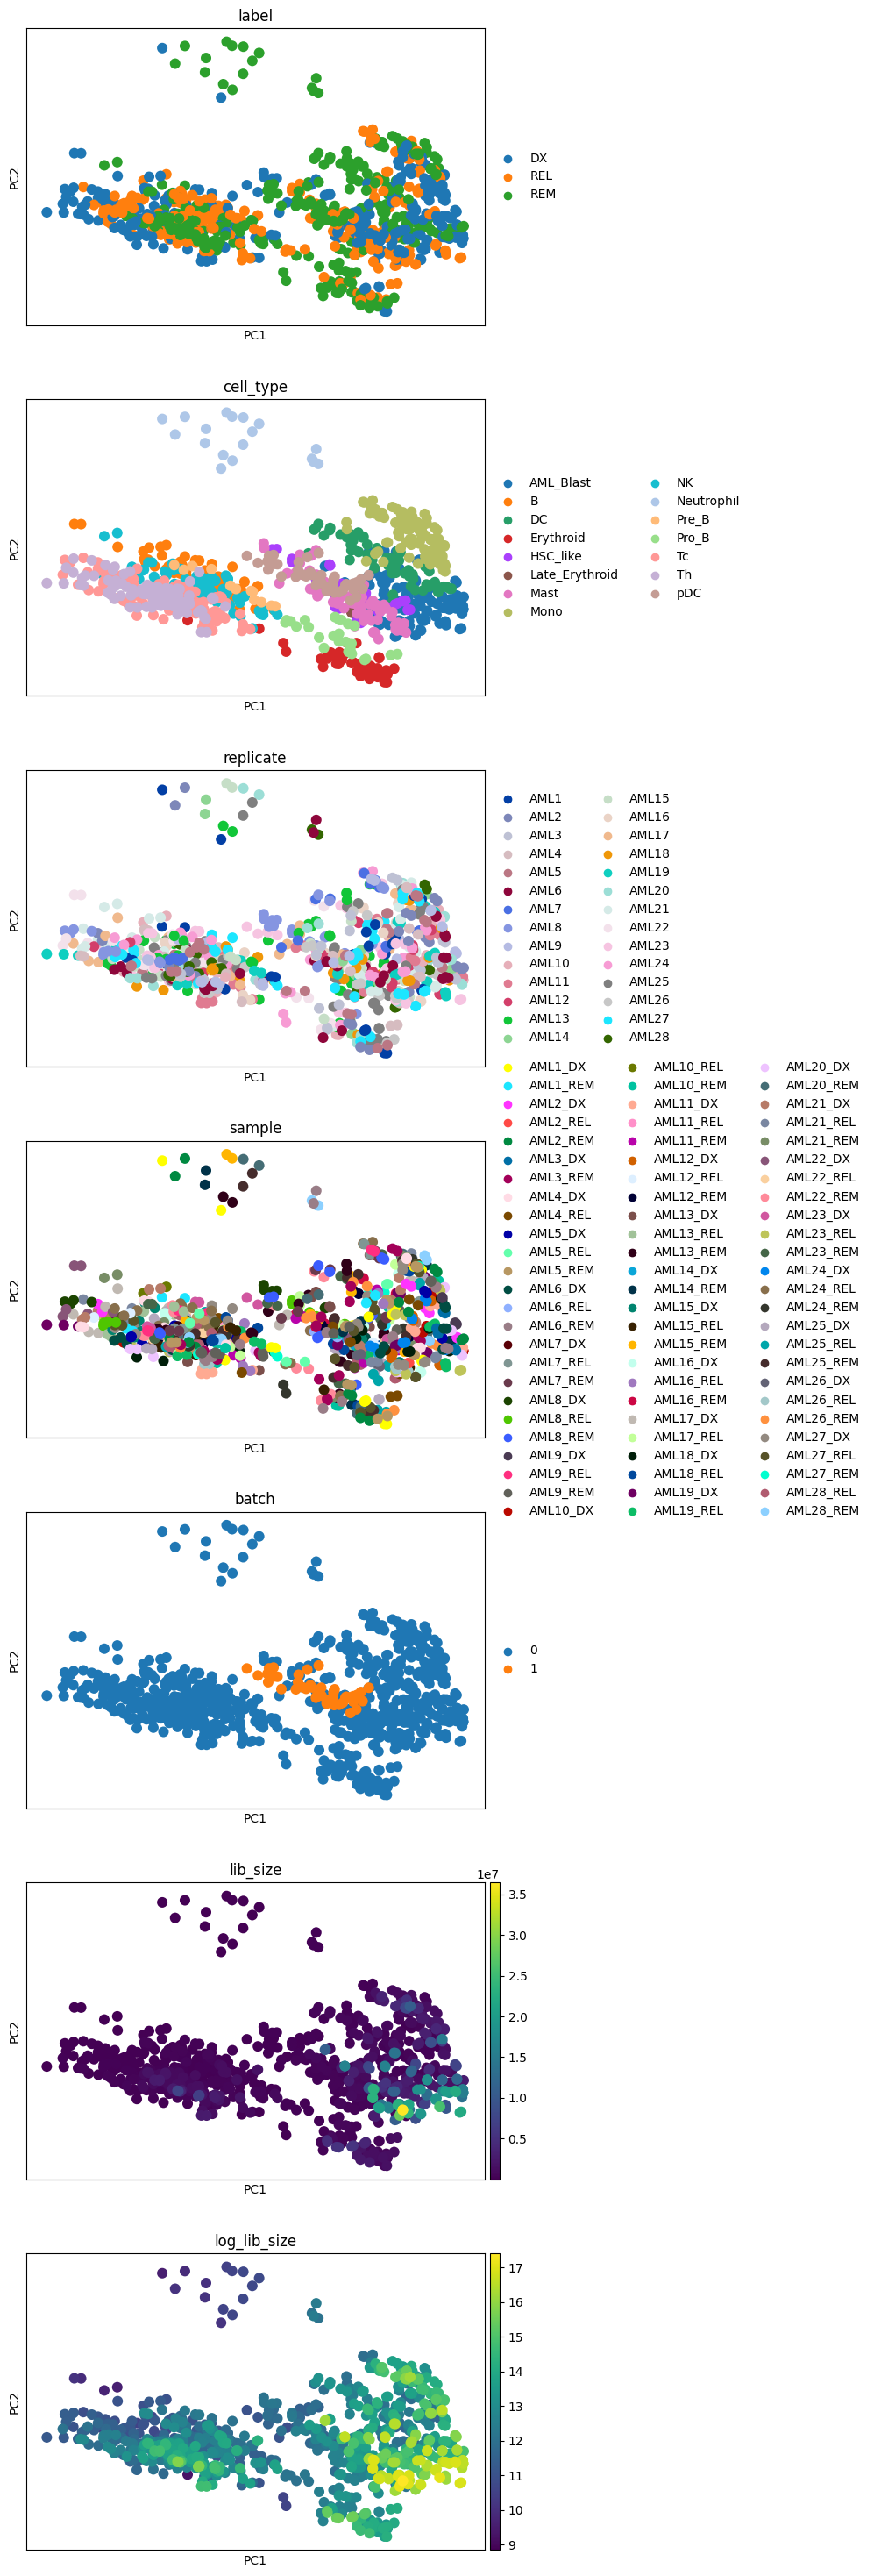

In [33]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

We see some speration of cell types on the PCA plots, the batch doesn't seem to correlated with PCA components as well. We do see some samples not appear at the DX time point, but we will ignore it for now.

In [34]:
# Passing raw counts back to .X for edgeR
adata_pb.X = adata_pb.layers['counts'].copy()

In [35]:
adata_pb

AnnData object with n_obs × n_vars = 978 × 21163
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

#### Constructing Design Matrix and Testing for All Cell Types

In [37]:
import numpy as np
import scipy.sparse

# Ensure adata_pb.X is a numerical type (float or int)
if isinstance(adata_pb.X, np.ndarray):
    # If it's not numeric, convert it
    if adata_pb.X.dtype == 'O':  # 'O' indicates an object type (not numeric)
        adata_pb.X = np.array(adata_pb.X, dtype=float)

# Check if adata_pb.X is sparse, and convert if it's not
if not scipy.sparse.issparse(adata_pb.X):
    adata_pb.X = scipy.sparse.csc_matrix(adata_pb.X)

# Ensure adata_pb.layers['counts'] is a numerical type (float or int)
if isinstance(adata_pb.layers['counts'], np.ndarray):
    if adata_pb.layers['counts'].dtype == 'O':  # 'O' indicates object type
        adata_pb.layers['counts'] = np.array(adata_pb.layers['counts'], dtype=float)

# Check if adata_pb.layers['counts'] is sparse, and convert if it's not
if not scipy.sparse.issparse(adata_pb.layers['counts']):
    adata_pb.layers['counts'] = scipy.sparse.csc_matrix(adata_pb.layers['counts'])


In [38]:
# Ensure .obsm['X_pca'] is sparse
if isinstance(adata_pb.obsm['X_pca'], np.ndarray):
    if adata_pb.obsm['X_pca'].dtype == 'O':  # 'O' indicates object type
        adata_pb.obsm['X_pca'] = np.array(adata_pb.obsm['X_pca'], dtype=float)

if not scipy.sparse.issparse(adata_pb.obsm['X_pca']):
    adata_pb.obsm['X_pca'] = scipy.sparse.csc_matrix(adata_pb.obsm['X_pca'])


In [39]:
# Convert all columns in adata.obs to string type
adata_pb.obs = adata_pb.obs.astype(str)

# Alternatively, if you want to convert object-type columns to category
for col in adata_pb.obs.columns:
    if adata_pb.obs[col].dtype == 'object':
        adata_pb.obs[col] = adata_pb.obs[col].astype('category')


In [66]:
adata_pb.obs['replicate'] = adata_pb.obs.pop('Patient')

In [67]:
adata_pb

AnnData object with n_obs × n_vars = 489 × 21163
    obs: 'DX', 'cell_type', 'sample', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'log1p', 'pca', 'DX_colors', 'cell_type_colors', 'Patient_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [40]:
# Re-sanitizing names because I forgot about Cell-Type names earlier : (

# Function to sanitize names for R compatibility
def sanitize_for_r(names):
    # Replace spaces, dashes, and other invalid characters with underscores
    return names.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)

# Sanitize 'cell_type' and 'sample' columns in the adata_pb.obs DataFrame
adata_pb.obs['cell_type'] = sanitize_for_r(adata_pb.obs['cell_type'])
adata_pb.obs['sample'] = sanitize_for_r(adata_pb.obs['sample'])

####  Passing to R to construct design matrix + DE testing

In [41]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

[1] "Dimensions before subsetting:"
[1] 21163   978
[1] ""
[1] "Dimensions after subsetting:"
[1] 5570  978
[1] ""


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
4: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


CPU times: user 15min 31s, sys: 1.66 s, total: 15min 32s
Wall time: 15min 42s


In [42]:
%%R
fit <- outs$fit
y <- outs$y

In [ ]:
# Diff E Analysis in R

In [45]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()

for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    
    # Define contrast names
    contrast_rel_dx <- paste0("groupREL.", cell_type, " - groupDX.", cell_type)
    contrast_rem_dx <- paste0("groupREM.", cell_type, " - groupDX.", cell_type)

    # Check if both contrasts exist in the design matrix
    if (all(c(paste0("groupREL.", cell_type), paste0("groupDX.", cell_type)) %in% colnames(y$design))) {
        myContrastREL <- makeContrasts(contrasts = contrast_rel_dx, levels = y$design)
        qlfREL <- glmQLFTest(fit, contrast=myContrastREL)
        ttREL <- topTags(qlfREL, n = Inf)
        de_per_cell_type[[paste0(cell_type, "_REL_vs_DX")]] <- ttREL$table
    } else {
        message("Skipping ", cell_type, " for REL vs. DX (not in design matrix)")
    }

    if (all(c(paste0("groupREM.", cell_type), paste0("groupDX.", cell_type)) %in% colnames(y$design))) {
        myContrastREM <- makeContrasts(contrasts = contrast_rem_dx, levels = y$design)
        qlfREM <- glmQLFTest(fit, contrast=myContrastREM)
        ttREM <- topTags(qlfREM, n = Inf)
        de_per_cell_type[[paste0(cell_type, "_REM_vs_DX")]] <- ttREM$table
    } else {
        message("Skipping ", cell_type, " for REM vs. DX (not in design matrix)")
    }
}

[1] "AML_Blast"
[1] "B"
[1] "DC"
[1] "Erythroid"
[1] "HSC_like"
[1] "Late_Erythroid"
[1] "Mast"
[1] "Mono"
[1] "NK"
[1] "Neutrophil"
[1] "Pre_B"
[1] "Pro_B"
[1] "Tc"
[1] "Th"
[1] "pDC"


Skipping HSC_like for REM vs. DX (not in design matrix)
Skipping Late_Erythroid for REL vs. DX (not in design matrix)
Skipping Late_Erythroid for REM vs. DX (not in design matrix)
Skipping Neutrophil for REL vs. DX (not in design matrix)


In [46]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

In [47]:
# Normalizing to see expresison differences easier
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [100]:
adata

AnnData object with n_obs × n_vars = 300690 × 21163
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'cell_type', 'label', 'sample', 'replicate'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'overcluster', 'umap', 'edgeR_AML_Blast_REL_vs_DX', 'edgeR_AML_Blast_REM_vs_DX', 'edgeR_B_REL_vs_DX', 'edgeR_B_REM_vs_DX', 'edgeR_DC_REL_vs_DX', 'edgeR_DC_REM_vs_DX', 'edgeR_Erythroid_REL_vs_DX', 'edgeR_Erythroid_REM_vs_DX', 'edgeR_HSC_like_REL_vs_DX', 'edgeR_Mast_REL_vs_DX', 'edgeR_Mast_REM_vs_DX', 'edgeR_Mono_REL_vs_DX', 'edgeR_Mono_REM_vs_DX', 'edgeR_NK_REL_vs_DX', 'edgeR_NK_REM_vs_DX', 'edgeR_Neutrophil_REM_vs_DX', 'edgeR_Pre_B